Triaxial test: Tridimensional
final normal strain in z direction:  0.0022523234850500068
final normal stress in z direction:  300.0 Pa
final von Mises stress:  400.0 Pa
final hydrostatic pressure:  433.3333333333333 Pa
final pre-consolidation pressure:  400.0 Pa


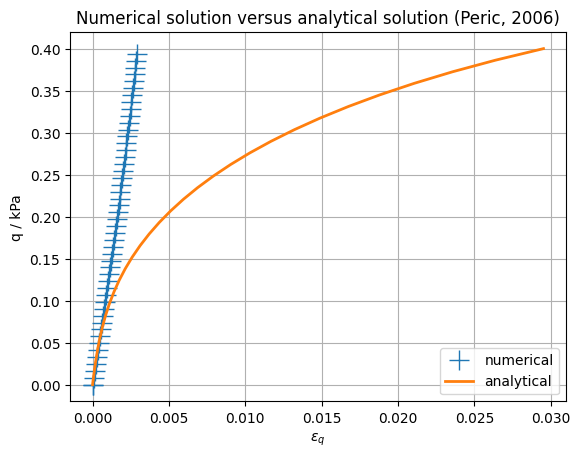

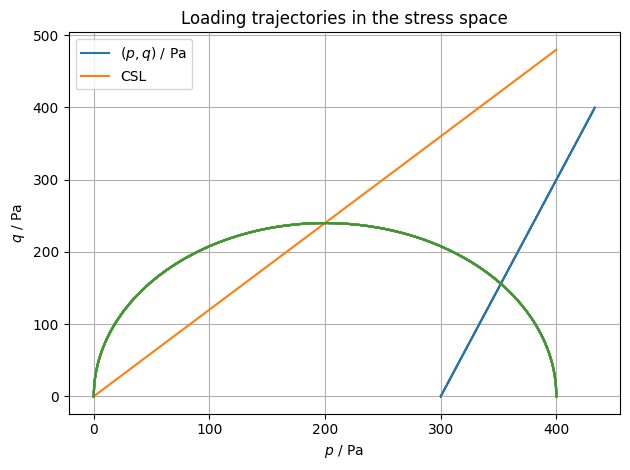

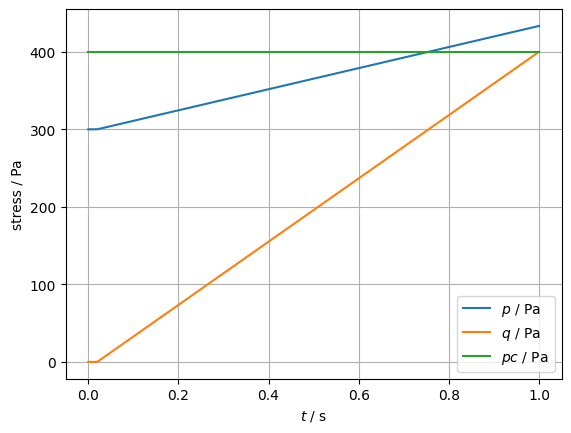

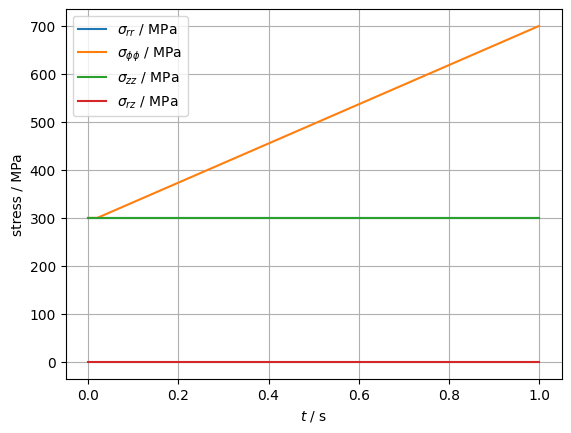

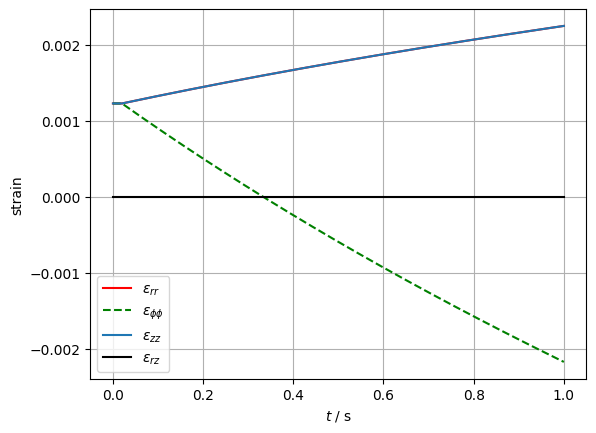

In [1]:
import os
import sys
sys.path.append("/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib/python3.11/site-packages")
import matplotlib.pyplot as plt
import numpy as np
import mtest

m = mtest.MTest()
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)
m.setMaximumNumberOfSubSteps(20)
m.setModellingHypothesis("Tridimensional")

mcc_models = [
    "ModCamClay_semiExpl",
    "ModCamClay_semiExpl_absP",
    "ModCamClay_semiExpl_constE",
]
controls = ["stress", "strain"]

# Set MCC material model implementation and path
# lib_path = "./src/libBehaviour.so"
lib_path = "/mofem_install/jupyter/thomas/mfront_interface/src/libBehaviour.so"
mcc_model = mcc_models[0]
control = controls[0]

m.setBehaviour("generic", lib_path, mcc_model)

# Material constants (according to Modified Cam clay model Report)
nu = 0.3  # Poisson ratio
la = 7.7e-2  # Slope of the virgin consolidation line
ka = 6.6e-3  # Slope of the swelling line
M = 1.2  # Slope of the critical state line (CSL)
v0 = 1.7857  # Initial volume ratio
pc0 = 400  # Initial pre-consolidation pressure in Pa
phi0 = 1 - 1 / v0  # Initial porosity
pamb = 0.0  # Ambient pressure in Pa

# Loading programme
tMax = 1.0  # s , total time
nTime = 200
ltime = np.linspace(0.0, tMax, nTime)

p_con =  300 # confining pressure
p_axi = 700  # axial pressure, +12614 for reaching CSL

# Young's modulus: consistent initial value for the models
E0 = 3 * (1 - 2 * nu) / (1 - phi0) * p_con / ka

e_con = p_con * (1 - 2 * nu) / E0
e_axi = 16 * e_con

# Environment parameters
m.setExternalStateVariable("Temperature", 293.15)

# Material parameters
if mcc_model == "ModCamClay_semiExpl_constE":
    m.setMaterialProperty("YoungModulus", E0)
    m.setParameter("AmbientPressure", pamb)
    print("Young Modulus set to E =", E0 / 1e6, " MPa")
if mcc_model in (
    "ModCamClay_semiExpl",
    "ModCamClay_semiExpl_absP",
):
    m.setMaterialProperty("InitialVolumeRatio", v0)
m.setMaterialProperty("PoissonRatio", nu)
m.setMaterialProperty("CriticalStateLineSlope", M)
m.setMaterialProperty("SwellingLineSlope", ka)
m.setMaterialProperty("VirginConsolidationLineSlope", la)
m.setMaterialProperty("CharacteristicPreConsolidationPressure", pc0)

# Initial values
m.setInternalStateVariableInitialValue("PreConsolidationPressure", pc0)
m.setInternalStateVariableInitialValue("PlasticVolumetricStrain", 0)
m.setInternalStateVariableInitialValue("VolumeRatio", v0)

# Set initial stress and strain state
eps_init = [e_con, e_con, e_con, 0.0, 0.0, 0.0]
sig_init = [p_con, p_con, p_con, 0.0, 0.0, 0.0]
m.setStress(sig_init)
m.setStrain(eps_init)

m.setImposedStress("SXX", {0: p_con, 0.02: p_con, 1.0: p_con})
m.setImposedStress("SYY", {0: p_con, 0.02: p_con, 1.0: p_con})

if control == "stress":
    # stress-controlled: works only until reaching the CSL
    m.setImposedStress("SZZ", {0: p_con, 0.02: p_con, 1.0: p_axi})
if control == "strain":
    raise NotImplementedError("Not implemented")
    # Strain-controlled: works, CSL reached asymptotically for EZZ->inf
    # m.setImposedStrain("EZZ", {0: -e_con, 0.02: -e_con, 1.0: -e_axi})
    # print("confining strain in z direction: ", e_con)

s = mtest.MTestCurrentState()
wk = mtest.MTestWorkSpace()
m.completeInitialisation()
m.initializeCurrentState(s)
m.initializeWorkSpace(wk)

# initialize output lists
pCurve = np.array([p_con])
qCurve = np.array([0.0])
eVCurve = np.array([0.0])
eQCurve = np.array([0.0])
lpCurve = np.array([0.0])
pcCurve = np.array([pc0])
phiCurve = np.array([phi0])
strains = np.empty(shape=(4, nTime))
stresses = np.empty(shape=(4, nTime))

# stresses[0][:] = sig_init
for k in range(4):
    strains[k][0] = eps_init[k]

for k in range(4):
    stresses[k][0] = sig_init[k]

# initialize yield functions
nPoints = 1000
pRange = np.empty(shape=(nTime, nPoints))
qFunct = np.empty(shape=(nTime, nPoints))

# run sim
for i in range(nTime - 1):
    m.execute(s, wk, ltime[i], ltime[i + 1])

    # output variables:
    pressure = (s.s1[0] + s.s1[1] + s.s1[2]) / 3
    vMstress = np.sqrt(
        0.5
        * (
            (s.s1[0] - s.s1[1]) ** 2
            + (s.s1[1] - s.s1[2]) ** 2
            + (s.s1[2] - s.s1[0]) ** 2
            + 3 * s.s1[3] ** 2
        )
    )
    epsilonV = s.e1[0] + s.e1[1] + s.e1[2]
    argument = (
        2
        * (
            s.e1[0] ** 2
            + s.e1[1] ** 2
            + s.e1[2] ** 2
            - epsilonV**2 / 3
            + 2 * s.e1[3] ** 2
        )
        / 3
    )
    vMstrain = np.sqrt(max(argument, 0))
    eplEquiv = s.getInternalStateVariableValue("EquivalentPlasticStrain")
    porosity = 1 - 1 / s.getInternalStateVariableValue("VolumeRatio")
    pc = s.getInternalStateVariableValue("PreConsolidationPressure")
    eplV = s.getInternalStateVariableValue("PlasticVolumetricStrain")

    pCurve = np.append(pCurve, pressure)
    qCurve = np.append(qCurve, vMstress)
    phiCurve = np.append(phiCurve, porosity)
    pcCurve = np.append(pcCurve, pc)
    eVCurve = np.append(eVCurve, epsilonV)
    eQCurve = np.append(eQCurve, vMstrain)
    lpCurve = np.append(lpCurve, eplEquiv)

    for k in range(4):
        strains[k][i + 1] = s.e1[k]

    for k in range(4):
        stresses[k][i + 1] = s.s1[k]

    # calculate the yield surfaces in the p-q-space
    pRange[i] = np.linspace(0, pc, nPoints)
    qFunct[i] = M * np.sqrt(pRange[i] * (pc - pRange[i]))

# calculate the theoretical CSL
pRangeCSL = np.linspace(0, pc0 / 2, nPoints)
pRangeCSL = pRange[nTime - 2]
qFunctCSL = M * pRangeCSL

# calculate the analytical reference solution according to Peric (2006)
a = 3 * (1 - 2 * nu) / (2 * (1 + nu))
k = vMstress / (pressure - pc0)
c = (la - ka) / M
nP = 30
qRangeAna = np.linspace(0.0, vMstress, nP)
pRangeAna = np.linspace(pc0, pressure, nP)
x = qRangeAna / (M * pRangeAna)
y = 1 - qRangeAna / (k * pRangeAna)  # = (pc0/pRangeAna)

v0xEpsQp = np.log(
    np.power((1 - x), c * k / (M - k)) * np.power((1 + x), c * k / (M + k))
) - 2 * c * np.arctan(x)
v0xEpsQe = np.log(np.power(y, 2 * c / (k / M - M / k) - ka * k / (3 * a)))
v0xEpsQ = v0xEpsQe + v0xEpsQp

# print some final values
print(f"Triaxial test: Tridimensional")
print("final normal strain in z direction: ", s.e1[1])
print("final normal stress in z direction: ", s.s1[1], "Pa")
print("final von Mises stress: ", vMstress, "Pa")
print("final hydrostatic pressure: ", pressure, "Pa")
print("final pre-consolidation pressure: ", pc, "Pa")

result_dir = f"/mofem_install/jupyter/thomas/mfront_interface/results/MCC_sig_1_{p_axi}MPa/"
os.makedirs(result_dir,exist_ok=True)

# plots
fig, ax = plt.subplots()
ax.set_title("Numerical solution versus analytical solution (Peric, 2006)")
ax.plot(eQCurve, qCurve / 1e3, "+", markersize=14, markevery=4, label="numerical")
ax.plot(v0xEpsQ / v0, qRangeAna / 1e3, linewidth=2, label="analytical")
ax.set_xlabel(r"$\epsilon_{q}$")
ax.set_ylabel("q / kPa")
ax.grid()
ax.legend()
fig.savefig(f"{result_dir}/Triaxial_NumVsAnal.pdf")

fig, ax = plt.subplots()
ax.set_title("Loading trajectories in the stress space")
ax.plot(pCurve, qCurve, label="$(p,q)$ / Pa")
plt.quiver(
    pCurve[:-1],
    qCurve[:-1],
    pCurve[1:] - pCurve[:-1],
    qCurve[1:] - qCurve[:-1],
    scale_units="xy",
    angles="xy",
    scale=1,
)
ax.plot(pRangeCSL, qFunctCSL, label="CSL")
for k in range(0, nTime - 1, 20):
    ax.plot(pRange[k], qFunct[k])
ax.plot(pRange[nTime - 2], qFunct[nTime - 2])
ax.set_xlabel("$p$ / Pa")
ax.set_ylabel("$q$ / Pa")
ax.grid()
ax.legend()
fig.tight_layout()
fig.show()
fig.savefig(f"{result_dir}/Triaxial_YieldSurface.pdf")

fig, ax = plt.subplots()
ax.plot(ltime, pCurve, label="$p$ / Pa")
ax.plot(ltime, qCurve, label="$q$ / Pa")
ax.plot(ltime, pcCurve, label="$pc$ / Pa")
ax.set_xlabel("$t$ / s")
ax.set_ylabel("stress / Pa")
ax.grid()
ax.legend()

fig, ax = plt.subplots()
ax.plot(ltime, stresses[0][:], label=r"$\sigma_{rr}$ / MPa")
ax.plot(ltime, stresses[2][:], label=r"$\sigma_{\phi\phi}$ / MPa")
ax.plot(ltime, stresses[1][:], label=r"$\sigma_{zz}$ / MPa")
ax.plot(ltime, stresses[3][:], label=r"$\sigma_{rz}$ / MPa")
ax.set_xlabel("$t$ / s")
ax.set_ylabel("stress / MPa")
ax.grid()
ax.legend()

fig, ax = plt.subplots()
ax.plot(ltime, strains[0][:], color="red", label=r"$\epsilon_{rr}$")
ax.plot(ltime, strains[2][:], "--", color="green", label=r"$\epsilon_{\phi\phi}$")
ax.plot(ltime, strains[1][:], label=r"$\epsilon_{zz}$")
ax.plot(ltime, strains[3][:], color="black", label=r"$\epsilon_{rz}$")
ax.set_xlabel("$t$ / s")
ax.set_ylabel("strain")
ax.grid()
ax.legend(loc="lower left")
fig.savefig(f"{result_dir}/Triaxial_Strains.pdf")


# fig, ax = plt.subplots()
# ax.plot(ltime, phiCurve - phi0, label=r"$\phi-\phi_0$")
# ax.plot(ltime, eVCurve, label=r"$\epsilon_{V}$")
# ax.plot(ltime, lpCurve, label=r"$\epsilon_{eq}$")
# ax.set_xlabel("$t$ / s")
# ax.set_ylabel(" ")
# ax.grid()
# ax.legend()

# plt.show()
